In [4]:
import tensorflow as tf
import keras

In [6]:
print(tf.__version__)
print(keras.__version__)

2.1.0
2.3.1


In [10]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from keras.models import Sequential, Model

In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
import os
if not os.path.exists('./gan_images'):
    os.makedirs('./gan_images')

In [15]:
np.random.seed(3)
tf.random.set_seed(3)

In [17]:
# 생성자 모델을 만든다.
generator = Sequential()
generator.add(Dense(128*7*7, input_dim = 100, activation = LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

In [19]:
# 판별자 모델을 만든다.
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides = 2, input_shape = (28, 28, 1),
                         padding = 'same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

In [20]:
discriminator.compile(loss = 'binary_crossentropy', optimizer = 'adam')

In [21]:
discriminator.trainable = False

In [22]:
ginput = Input(shape = (100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss = 'binary_crossentropy', optimizer = 'adam')
gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [27]:
#신경망을 실행시키는 함수를 만듭니다.
def gan_train(epoch, batch_size, saving_interval):

  # MNIST 데이터 불러오기

  (X_train, _), (_, _) = keras.datasets.mnist.load_data()  # 앞서 불러온 적 있는 MNIST를 다시 이용합니다. 단, 테스트과정은 필요없고 이미지만 사용할 것이기 때문에 X_train만 불러왔습니다.
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
  X_train = (X_train - 127.5) / 127.5  # 픽셀값은 0에서 255사이의 값입니다. 이전에 255로 나누어 줄때는 이를 0~1사이의 값으로 바꾸었던 것인데, 여기서는 127.5를 빼준 뒤 127.5로 나누어 줌으로 인해 -1에서 1사이의 값으로 바뀌게 됩니다.
  #X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
          # 실제 데이터를 판별자에 입력하는 부분입니다.
          idx = np.random.randint(0, X_train.shape[0], batch_size)
          imgs = X_train[idx]
          d_loss_real = discriminator.train_on_batch(imgs, true)

          #가상 이미지를 판별자에 입력하는 부분입니다.
          noise = np.random.normal(0, 1, (batch_size, 100))
          gen_imgs = generator.predict(noise)
          d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

          #판별자와 생성자의 오차를 계산합니다.
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
          g_loss = gan.train_on_batch(noise, true)

          print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        # 이부분은 중간 과정을 이미지로 저장해 주는 부분입니다. 본 장의 주요 내용과 관련이 없어
        # 소스코드만 첨부합니다. 만들어진 이미지들은 gan_images 폴더에 저장됩니다.
          if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("gan_images/gan_mnist_%d.png" % i)

C:\Users\14\.conda\envs\gan_env\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\14\.conda\envs\gan_env\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch:0  d_loss:0.6728  g_loss:0.3809


C:\Users\14\.conda\envs\gan_env\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch:1  d_loss:0.4472  g_loss:0.0749
epoch:2  d_loss:0.5108  g_loss:0.0115
epoch:3  d_loss:0.7451  g_loss:0.0129
epoch:4  d_loss:0.7001  g_loss:0.0753
epoch:5  d_loss:0.5442  g_loss:0.3384
epoch:6  d_loss:0.4705  g_loss:0.7662
epoch:7  d_loss:0.4914  g_loss:0.9923
epoch:8  d_loss:0.4712  g_loss:1.0813
epoch:9  d_loss:0.4352  g_loss:1.0875
epoch:10  d_loss:0.4092  g_loss:0.9669
epoch:11  d_loss:0.3282  g_loss:1.0095
epoch:12  d_loss:0.2954  g_loss:0.8486
epoch:13  d_loss:0.4267  g_loss:0.8616
epoch:14  d_loss:0.3781  g_loss:1.0435
epoch:15  d_loss:0.5491  g_loss:0.7132
epoch:16  d_loss:0.7809  g_loss:0.8930
epoch:17  d_loss:0.9819  g_loss:0.6979
epoch:18  d_loss:0.7336  g_loss:0.8935
epoch:19  d_loss:0.6231  g_loss:0.8558
epoch:20  d_loss:0.5651  g_loss:1.1448
epoch:21  d_loss:0.4242  g_loss:1.1261
epoch:22  d_loss:0.4270  g_loss:1.0201
epoch:23  d_loss:0.4804  g_loss:0.8655
epoch:24  d_loss:0.4390  g_loss:0.7870
epoch:25  d_loss:0.4773  g_loss:0.9216
epoch:26  d_loss:0.3858  g_loss:1.

epoch:209  d_loss:0.4373  g_loss:1.8793
epoch:210  d_loss:0.4975  g_loss:1.8280
epoch:211  d_loss:0.3560  g_loss:1.9041
epoch:212  d_loss:0.3596  g_loss:2.2159
epoch:213  d_loss:0.4478  g_loss:2.3059
epoch:214  d_loss:0.3519  g_loss:2.0111
epoch:215  d_loss:0.3559  g_loss:2.2195
epoch:216  d_loss:0.4380  g_loss:2.3227
epoch:217  d_loss:0.3821  g_loss:2.7615
epoch:218  d_loss:0.2786  g_loss:2.8478
epoch:219  d_loss:0.3168  g_loss:2.5473
epoch:220  d_loss:0.4780  g_loss:2.0067
epoch:221  d_loss:0.3179  g_loss:2.3702
epoch:222  d_loss:0.3513  g_loss:2.1286
epoch:223  d_loss:0.3478  g_loss:2.8084
epoch:224  d_loss:0.3427  g_loss:2.4324
epoch:225  d_loss:0.4142  g_loss:2.2362
epoch:226  d_loss:0.2826  g_loss:2.5719
epoch:227  d_loss:0.3620  g_loss:3.0148
epoch:228  d_loss:0.4506  g_loss:2.5368
epoch:229  d_loss:0.4692  g_loss:1.9260
epoch:230  d_loss:0.4037  g_loss:2.1391
epoch:231  d_loss:0.4238  g_loss:2.4578
epoch:232  d_loss:0.4370  g_loss:2.3001
epoch:233  d_loss:0.5310  g_loss:2.2810


epoch:414  d_loss:0.3439  g_loss:2.4213
epoch:415  d_loss:0.3175  g_loss:1.9150
epoch:416  d_loss:0.4008  g_loss:2.4219
epoch:417  d_loss:0.3482  g_loss:2.3499
epoch:418  d_loss:0.3731  g_loss:2.4182
epoch:419  d_loss:0.3568  g_loss:2.1136
epoch:420  d_loss:0.2986  g_loss:2.4843
epoch:421  d_loss:0.3649  g_loss:2.1498
epoch:422  d_loss:0.3792  g_loss:1.9636
epoch:423  d_loss:0.2761  g_loss:1.7172
epoch:424  d_loss:0.3699  g_loss:1.7254
epoch:425  d_loss:0.2449  g_loss:2.3462
epoch:426  d_loss:0.4105  g_loss:3.3120
epoch:427  d_loss:0.3037  g_loss:3.0788
epoch:428  d_loss:0.4021  g_loss:2.2682
epoch:429  d_loss:0.4664  g_loss:1.7828
epoch:430  d_loss:0.3324  g_loss:1.6344
epoch:431  d_loss:0.2585  g_loss:2.1499
epoch:432  d_loss:0.3169  g_loss:2.2321
epoch:433  d_loss:0.3521  g_loss:2.0192
epoch:434  d_loss:0.2920  g_loss:2.3215
epoch:435  d_loss:0.2695  g_loss:2.2083
epoch:436  d_loss:0.2157  g_loss:2.6225
epoch:437  d_loss:0.2422  g_loss:2.4435
epoch:438  d_loss:0.2259  g_loss:2.6010


epoch:619  d_loss:0.5938  g_loss:1.6740
epoch:620  d_loss:0.5069  g_loss:1.2993
epoch:621  d_loss:0.2682  g_loss:1.6942
epoch:622  d_loss:0.5060  g_loss:1.2412
epoch:623  d_loss:0.4374  g_loss:1.5624
epoch:624  d_loss:0.3432  g_loss:1.5794
epoch:625  d_loss:0.6082  g_loss:1.2841
epoch:626  d_loss:0.5344  g_loss:1.6995
epoch:627  d_loss:0.6317  g_loss:2.7650
epoch:628  d_loss:0.4074  g_loss:2.2464
epoch:629  d_loss:0.8574  g_loss:1.4125
epoch:630  d_loss:0.5772  g_loss:1.9817
epoch:631  d_loss:0.1284  g_loss:3.5968
epoch:632  d_loss:0.4267  g_loss:3.9419
epoch:633  d_loss:0.4153  g_loss:3.2037
epoch:634  d_loss:0.5924  g_loss:2.0909
epoch:635  d_loss:0.8530  g_loss:0.8910
epoch:636  d_loss:1.5112  g_loss:0.5675
epoch:637  d_loss:1.1055  g_loss:1.0013
epoch:638  d_loss:1.2895  g_loss:3.9244
epoch:639  d_loss:0.7708  g_loss:5.1054
epoch:640  d_loss:1.2026  g_loss:2.9303
epoch:641  d_loss:1.5395  g_loss:1.2060
epoch:642  d_loss:2.1951  g_loss:0.6844
epoch:643  d_loss:2.1977  g_loss:0.9635


epoch:824  d_loss:0.2736  g_loss:2.5388
epoch:825  d_loss:0.2490  g_loss:2.7180
epoch:826  d_loss:0.2101  g_loss:2.9234
epoch:827  d_loss:0.2853  g_loss:2.4821
epoch:828  d_loss:0.3128  g_loss:2.4637
epoch:829  d_loss:0.2939  g_loss:2.7747
epoch:830  d_loss:0.4174  g_loss:2.1241
epoch:831  d_loss:0.3560  g_loss:2.6017
epoch:832  d_loss:0.3069  g_loss:2.2933
epoch:833  d_loss:0.3171  g_loss:2.4616
epoch:834  d_loss:0.4164  g_loss:2.2183
epoch:835  d_loss:0.4153  g_loss:1.9610
epoch:836  d_loss:0.3481  g_loss:1.7304
epoch:837  d_loss:0.3207  g_loss:1.9901
epoch:838  d_loss:0.5299  g_loss:1.8103
epoch:839  d_loss:0.4356  g_loss:2.0194
epoch:840  d_loss:0.4552  g_loss:1.7121
epoch:841  d_loss:0.6021  g_loss:1.5479
epoch:842  d_loss:0.5373  g_loss:1.6272
epoch:843  d_loss:0.6340  g_loss:2.2237
epoch:844  d_loss:0.6851  g_loss:1.8873
epoch:845  d_loss:0.5624  g_loss:1.7155
epoch:846  d_loss:0.6024  g_loss:1.7091
epoch:847  d_loss:0.5200  g_loss:1.8770
epoch:848  d_loss:0.6002  g_loss:1.6145


epoch:1029  d_loss:0.5507  g_loss:2.1867
epoch:1030  d_loss:0.5948  g_loss:1.4868
epoch:1031  d_loss:0.4751  g_loss:1.9713
epoch:1032  d_loss:0.4910  g_loss:2.3972
epoch:1033  d_loss:0.7059  g_loss:1.8593
epoch:1034  d_loss:0.5283  g_loss:2.0609
epoch:1035  d_loss:0.5503  g_loss:1.8394
epoch:1036  d_loss:0.7249  g_loss:1.6256
epoch:1037  d_loss:0.4959  g_loss:1.6839
epoch:1038  d_loss:0.5646  g_loss:1.9887
epoch:1039  d_loss:0.6125  g_loss:1.8961
epoch:1040  d_loss:0.4680  g_loss:1.4864
epoch:1041  d_loss:0.4915  g_loss:1.5410
epoch:1042  d_loss:0.6139  g_loss:1.5775
epoch:1043  d_loss:0.6297  g_loss:1.4172
epoch:1044  d_loss:0.3649  g_loss:1.6679
epoch:1045  d_loss:0.6537  g_loss:1.4981
epoch:1046  d_loss:0.4249  g_loss:1.7582
epoch:1047  d_loss:0.4037  g_loss:1.7830
epoch:1048  d_loss:0.3693  g_loss:2.4188
epoch:1049  d_loss:0.3477  g_loss:2.5256
epoch:1050  d_loss:0.3019  g_loss:2.6906
epoch:1051  d_loss:0.2114  g_loss:2.6707
epoch:1052  d_loss:0.1105  g_loss:3.0061
epoch:1053  d_lo

epoch:1229  d_loss:0.3092  g_loss:1.9510
epoch:1230  d_loss:0.3701  g_loss:1.9543
epoch:1231  d_loss:0.3428  g_loss:1.7918
epoch:1232  d_loss:0.4014  g_loss:1.7089
epoch:1233  d_loss:0.4189  g_loss:1.8809
epoch:1234  d_loss:0.3923  g_loss:1.6538
epoch:1235  d_loss:0.3959  g_loss:1.7476
epoch:1236  d_loss:0.4711  g_loss:1.4405
epoch:1237  d_loss:0.4322  g_loss:2.0428
epoch:1238  d_loss:0.3769  g_loss:2.1817
epoch:1239  d_loss:0.7004  g_loss:1.3158
epoch:1240  d_loss:0.3362  g_loss:1.8323
epoch:1241  d_loss:0.4927  g_loss:1.7094
epoch:1242  d_loss:0.6356  g_loss:1.6419
epoch:1243  d_loss:0.5948  g_loss:1.2693
epoch:1244  d_loss:0.5542  g_loss:1.6666
epoch:1245  d_loss:0.5398  g_loss:2.0118
epoch:1246  d_loss:0.4533  g_loss:1.8980
epoch:1247  d_loss:0.6057  g_loss:1.5058
epoch:1248  d_loss:0.5255  g_loss:1.4518
epoch:1249  d_loss:0.3901  g_loss:1.7928
epoch:1250  d_loss:0.5365  g_loss:1.4223
epoch:1251  d_loss:0.4315  g_loss:1.5691
epoch:1252  d_loss:0.4767  g_loss:1.2887
epoch:1253  d_lo

epoch:1429  d_loss:0.5298  g_loss:1.5725
epoch:1430  d_loss:0.3931  g_loss:1.5832
epoch:1431  d_loss:0.5848  g_loss:1.6314
epoch:1432  d_loss:0.4032  g_loss:1.6983
epoch:1433  d_loss:0.5023  g_loss:1.5935
epoch:1434  d_loss:0.4206  g_loss:1.6946
epoch:1435  d_loss:0.4738  g_loss:1.4734
epoch:1436  d_loss:0.4333  g_loss:2.1858
epoch:1437  d_loss:0.4359  g_loss:1.8067
epoch:1438  d_loss:0.4272  g_loss:1.8459
epoch:1439  d_loss:0.4451  g_loss:1.4848
epoch:1440  d_loss:0.4369  g_loss:1.6939
epoch:1441  d_loss:0.4606  g_loss:1.7593
epoch:1442  d_loss:0.4370  g_loss:2.5455
epoch:1443  d_loss:0.4853  g_loss:1.7373
epoch:1444  d_loss:0.3386  g_loss:1.8564
epoch:1445  d_loss:0.4231  g_loss:1.6718
epoch:1446  d_loss:0.3835  g_loss:1.8207
epoch:1447  d_loss:0.4334  g_loss:1.6580
epoch:1448  d_loss:0.3303  g_loss:1.8058
epoch:1449  d_loss:0.3876  g_loss:1.5292
epoch:1450  d_loss:0.4374  g_loss:1.7447
epoch:1451  d_loss:0.4391  g_loss:1.5062
epoch:1452  d_loss:0.3417  g_loss:1.8656
epoch:1453  d_lo

epoch:1629  d_loss:0.5322  g_loss:1.6963
epoch:1630  d_loss:0.5329  g_loss:1.9203
epoch:1631  d_loss:0.4920  g_loss:1.7785
epoch:1632  d_loss:0.3773  g_loss:1.5774
epoch:1633  d_loss:0.4093  g_loss:1.5241
epoch:1634  d_loss:0.3929  g_loss:2.2519
epoch:1635  d_loss:0.3752  g_loss:1.9992
epoch:1636  d_loss:0.3354  g_loss:2.0153
epoch:1637  d_loss:0.4323  g_loss:1.7614
epoch:1638  d_loss:0.3460  g_loss:1.6815
epoch:1639  d_loss:0.4312  g_loss:1.7490
epoch:1640  d_loss:0.4901  g_loss:1.5247
epoch:1641  d_loss:0.3510  g_loss:1.9184
epoch:1642  d_loss:0.3851  g_loss:1.8998
epoch:1643  d_loss:0.5431  g_loss:1.5979
epoch:1644  d_loss:0.3895  g_loss:1.6962
epoch:1645  d_loss:0.4864  g_loss:1.7181
epoch:1646  d_loss:0.4245  g_loss:1.8900
epoch:1647  d_loss:0.4140  g_loss:2.2814
epoch:1648  d_loss:0.5044  g_loss:1.7668
epoch:1649  d_loss:0.4883  g_loss:1.8523
epoch:1650  d_loss:0.4357  g_loss:1.5498
epoch:1651  d_loss:0.4763  g_loss:1.6693
epoch:1652  d_loss:0.5605  g_loss:1.4883
epoch:1653  d_lo

epoch:1829  d_loss:0.4182  g_loss:1.6200
epoch:1830  d_loss:0.4732  g_loss:1.8066
epoch:1831  d_loss:0.5852  g_loss:1.7775
epoch:1832  d_loss:0.5217  g_loss:1.4761
epoch:1833  d_loss:0.4476  g_loss:1.3078
epoch:1834  d_loss:0.5356  g_loss:1.3586
epoch:1835  d_loss:0.5088  g_loss:1.4655
epoch:1836  d_loss:0.4967  g_loss:1.6611
epoch:1837  d_loss:0.4796  g_loss:1.6140
epoch:1838  d_loss:0.5884  g_loss:1.4619
epoch:1839  d_loss:0.4643  g_loss:1.6026
epoch:1840  d_loss:0.6175  g_loss:1.5544
epoch:1841  d_loss:0.4723  g_loss:1.4094
epoch:1842  d_loss:0.5834  g_loss:1.0492
epoch:1843  d_loss:0.5757  g_loss:1.2735
epoch:1844  d_loss:0.5856  g_loss:1.5635
epoch:1845  d_loss:0.4266  g_loss:1.7023
epoch:1846  d_loss:0.5395  g_loss:1.8790
epoch:1847  d_loss:0.6570  g_loss:1.6228
epoch:1848  d_loss:0.4719  g_loss:1.3504
epoch:1849  d_loss:0.6158  g_loss:1.2111
epoch:1850  d_loss:0.5405  g_loss:1.1457
epoch:1851  d_loss:0.4961  g_loss:1.2510
epoch:1852  d_loss:0.4132  g_loss:1.6801
epoch:1853  d_lo

epoch:2029  d_loss:0.5291  g_loss:1.6719
epoch:2030  d_loss:0.4543  g_loss:1.6333
epoch:2031  d_loss:0.3521  g_loss:1.9055
epoch:2032  d_loss:0.6158  g_loss:1.9249
epoch:2033  d_loss:0.4751  g_loss:1.4495
epoch:2034  d_loss:0.7905  g_loss:1.5079
epoch:2035  d_loss:0.5377  g_loss:1.4919
epoch:2036  d_loss:0.6317  g_loss:1.6743
epoch:2037  d_loss:0.5283  g_loss:1.6900
epoch:2038  d_loss:0.4552  g_loss:1.5754
epoch:2039  d_loss:0.4995  g_loss:1.4067
epoch:2040  d_loss:0.6445  g_loss:1.4522
epoch:2041  d_loss:0.3532  g_loss:1.6316
epoch:2042  d_loss:0.5120  g_loss:1.4631
epoch:2043  d_loss:0.4371  g_loss:1.7042
epoch:2044  d_loss:0.3888  g_loss:1.9230
epoch:2045  d_loss:0.4808  g_loss:1.6246
epoch:2046  d_loss:0.5769  g_loss:1.4348
epoch:2047  d_loss:0.5003  g_loss:1.4943
epoch:2048  d_loss:0.5261  g_loss:1.7063
epoch:2049  d_loss:0.3565  g_loss:2.0535
epoch:2050  d_loss:0.3812  g_loss:1.8409
epoch:2051  d_loss:0.5185  g_loss:2.2401
epoch:2052  d_loss:0.3748  g_loss:1.6678
epoch:2053  d_lo

epoch:2229  d_loss:0.7865  g_loss:1.2096
epoch:2230  d_loss:0.4622  g_loss:1.4681
epoch:2231  d_loss:0.5915  g_loss:1.5955
epoch:2232  d_loss:0.6615  g_loss:1.6681
epoch:2233  d_loss:0.6004  g_loss:1.6948
epoch:2234  d_loss:0.6279  g_loss:1.6394
epoch:2235  d_loss:0.5633  g_loss:1.6514
epoch:2236  d_loss:0.5003  g_loss:1.8611
epoch:2237  d_loss:0.5704  g_loss:1.7103
epoch:2238  d_loss:0.5338  g_loss:1.2927
epoch:2239  d_loss:0.5443  g_loss:1.1204
epoch:2240  d_loss:0.5381  g_loss:1.2977
epoch:2241  d_loss:0.4537  g_loss:1.3571
epoch:2242  d_loss:0.5608  g_loss:1.3470
epoch:2243  d_loss:0.4723  g_loss:1.7317
epoch:2244  d_loss:0.5424  g_loss:1.9197
epoch:2245  d_loss:0.3690  g_loss:2.4802
epoch:2246  d_loss:0.3945  g_loss:2.5365
epoch:2247  d_loss:0.4413  g_loss:1.9959
epoch:2248  d_loss:0.4750  g_loss:1.6200
epoch:2249  d_loss:0.4099  g_loss:1.7185
epoch:2250  d_loss:0.2639  g_loss:1.4591
epoch:2251  d_loss:0.4774  g_loss:1.9289
epoch:2252  d_loss:0.5133  g_loss:1.9965
epoch:2253  d_lo

epoch:2429  d_loss:0.5539  g_loss:1.3873
epoch:2430  d_loss:0.4944  g_loss:1.5292
epoch:2431  d_loss:0.5017  g_loss:1.4795
epoch:2432  d_loss:0.4383  g_loss:1.6311
epoch:2433  d_loss:0.3610  g_loss:1.8463
epoch:2434  d_loss:0.3377  g_loss:2.1638
epoch:2435  d_loss:0.3724  g_loss:2.1612
epoch:2436  d_loss:0.4185  g_loss:2.0571
epoch:2437  d_loss:0.4676  g_loss:1.7310
epoch:2438  d_loss:0.3270  g_loss:1.9097
epoch:2439  d_loss:0.4923  g_loss:1.9382
epoch:2440  d_loss:0.4026  g_loss:2.3430
epoch:2441  d_loss:0.3389  g_loss:2.2830
epoch:2442  d_loss:0.4083  g_loss:2.1860
epoch:2443  d_loss:0.4515  g_loss:1.5205
epoch:2444  d_loss:0.4220  g_loss:2.0075
epoch:2445  d_loss:0.5180  g_loss:1.7981
epoch:2446  d_loss:0.3451  g_loss:2.0041
epoch:2447  d_loss:0.4400  g_loss:2.2167
epoch:2448  d_loss:0.4568  g_loss:1.7512
epoch:2449  d_loss:0.4041  g_loss:1.6084
epoch:2450  d_loss:0.4691  g_loss:1.7042
epoch:2451  d_loss:0.5031  g_loss:2.1381
epoch:2452  d_loss:0.4948  g_loss:1.8966
epoch:2453  d_lo

epoch:2629  d_loss:0.5650  g_loss:2.1304
epoch:2630  d_loss:0.5104  g_loss:1.6603
epoch:2631  d_loss:0.4544  g_loss:1.4383
epoch:2632  d_loss:0.4962  g_loss:1.2400
epoch:2633  d_loss:0.4788  g_loss:0.9781
epoch:2634  d_loss:0.6020  g_loss:1.3667
epoch:2635  d_loss:0.4190  g_loss:1.8419
epoch:2636  d_loss:0.3271  g_loss:2.2012
epoch:2637  d_loss:0.5305  g_loss:1.9340
epoch:2638  d_loss:0.6464  g_loss:1.7930
epoch:2639  d_loss:0.6075  g_loss:1.6207
epoch:2640  d_loss:0.7291  g_loss:1.4879
epoch:2641  d_loss:0.6901  g_loss:1.0277
epoch:2642  d_loss:0.4799  g_loss:1.3611
epoch:2643  d_loss:0.4736  g_loss:1.7234
epoch:2644  d_loss:0.5428  g_loss:1.3456
epoch:2645  d_loss:0.5016  g_loss:1.3084
epoch:2646  d_loss:0.5107  g_loss:1.2918
epoch:2647  d_loss:0.4896  g_loss:1.1951
epoch:2648  d_loss:0.4401  g_loss:1.6922
epoch:2649  d_loss:0.4039  g_loss:1.7718
epoch:2650  d_loss:0.4494  g_loss:1.4365
epoch:2651  d_loss:0.4584  g_loss:1.3846
epoch:2652  d_loss:0.5747  g_loss:1.5938
epoch:2653  d_lo

epoch:2829  d_loss:0.5145  g_loss:1.6073
epoch:2830  d_loss:0.4561  g_loss:1.2437
epoch:2831  d_loss:0.4736  g_loss:1.2428
epoch:2832  d_loss:0.3950  g_loss:1.6108
epoch:2833  d_loss:0.5699  g_loss:1.5075
epoch:2834  d_loss:0.4533  g_loss:1.8195
epoch:2835  d_loss:0.4924  g_loss:1.7710
epoch:2836  d_loss:0.5655  g_loss:1.5960
epoch:2837  d_loss:0.5213  g_loss:1.2306
epoch:2838  d_loss:0.4415  g_loss:1.5385
epoch:2839  d_loss:0.4276  g_loss:1.4168
epoch:2840  d_loss:0.3315  g_loss:1.7185
epoch:2841  d_loss:0.4379  g_loss:1.9140
epoch:2842  d_loss:0.5193  g_loss:1.9204
epoch:2843  d_loss:0.5159  g_loss:1.9731
epoch:2844  d_loss:0.5108  g_loss:1.6414
epoch:2845  d_loss:0.6138  g_loss:1.6750
epoch:2846  d_loss:0.4070  g_loss:1.3066
epoch:2847  d_loss:0.5457  g_loss:1.2249
epoch:2848  d_loss:0.4056  g_loss:1.6621
epoch:2849  d_loss:0.5105  g_loss:1.3861
epoch:2850  d_loss:0.4244  g_loss:1.9699
epoch:2851  d_loss:0.4536  g_loss:1.6331
epoch:2852  d_loss:0.6122  g_loss:1.5460
epoch:2853  d_lo

epoch:3029  d_loss:0.4562  g_loss:2.4158
epoch:3030  d_loss:0.4787  g_loss:1.9821
epoch:3031  d_loss:0.6170  g_loss:2.0412
epoch:3032  d_loss:0.4467  g_loss:1.3576
epoch:3033  d_loss:0.4212  g_loss:1.6193
epoch:3034  d_loss:0.5955  g_loss:1.1795
epoch:3035  d_loss:0.5656  g_loss:1.6058
epoch:3036  d_loss:0.5786  g_loss:1.5428
epoch:3037  d_loss:0.5373  g_loss:1.7456
epoch:3038  d_loss:0.6013  g_loss:1.8748
epoch:3039  d_loss:0.5022  g_loss:1.8696
epoch:3040  d_loss:0.4989  g_loss:1.6367
epoch:3041  d_loss:0.4270  g_loss:1.6445
epoch:3042  d_loss:0.6348  g_loss:1.5921
epoch:3043  d_loss:0.6313  g_loss:1.4679
epoch:3044  d_loss:0.4470  g_loss:1.6536
epoch:3045  d_loss:0.6049  g_loss:1.3951
epoch:3046  d_loss:0.4005  g_loss:1.8893
epoch:3047  d_loss:0.5662  g_loss:1.4699
epoch:3048  d_loss:0.4297  g_loss:1.6068
epoch:3049  d_loss:0.4730  g_loss:1.9631
epoch:3050  d_loss:0.4828  g_loss:2.0192
epoch:3051  d_loss:0.4847  g_loss:1.9652
epoch:3052  d_loss:0.5355  g_loss:1.9854
epoch:3053  d_lo

epoch:3229  d_loss:0.6461  g_loss:1.5850
epoch:3230  d_loss:0.5813  g_loss:1.6238
epoch:3231  d_loss:0.4230  g_loss:1.5209
epoch:3232  d_loss:0.5312  g_loss:1.3543
epoch:3233  d_loss:0.4087  g_loss:1.7875
epoch:3234  d_loss:0.4726  g_loss:1.8741
epoch:3235  d_loss:0.4583  g_loss:1.8842
epoch:3236  d_loss:0.5515  g_loss:1.8619
epoch:3237  d_loss:0.4603  g_loss:1.5932
epoch:3238  d_loss:0.3264  g_loss:2.0418
epoch:3239  d_loss:0.4590  g_loss:1.4916
epoch:3240  d_loss:0.4609  g_loss:1.7256
epoch:3241  d_loss:0.2872  g_loss:1.7525
epoch:3242  d_loss:0.4533  g_loss:2.2295
epoch:3243  d_loss:0.4930  g_loss:1.7668
epoch:3244  d_loss:0.4562  g_loss:1.7104
epoch:3245  d_loss:0.4418  g_loss:2.2438
epoch:3246  d_loss:0.3726  g_loss:1.6663
epoch:3247  d_loss:0.4144  g_loss:2.0686
epoch:3248  d_loss:0.4359  g_loss:1.7178
epoch:3249  d_loss:0.4822  g_loss:1.3715
epoch:3250  d_loss:0.4859  g_loss:1.3349
epoch:3251  d_loss:0.4820  g_loss:1.5347
epoch:3252  d_loss:0.4222  g_loss:1.4439
epoch:3253  d_lo

epoch:3429  d_loss:0.4200  g_loss:1.9564
epoch:3430  d_loss:0.4943  g_loss:1.5944
epoch:3431  d_loss:0.5384  g_loss:1.4653
epoch:3432  d_loss:0.3655  g_loss:1.5249
epoch:3433  d_loss:0.4905  g_loss:1.7410
epoch:3434  d_loss:0.5129  g_loss:1.7007
epoch:3435  d_loss:0.3841  g_loss:2.0489
epoch:3436  d_loss:0.4653  g_loss:1.9300
epoch:3437  d_loss:0.4783  g_loss:1.7777
epoch:3438  d_loss:0.5429  g_loss:1.4654
epoch:3439  d_loss:0.4414  g_loss:1.4547
epoch:3440  d_loss:0.4417  g_loss:1.1588
epoch:3441  d_loss:0.5387  g_loss:1.1751
epoch:3442  d_loss:0.5533  g_loss:1.3014
epoch:3443  d_loss:0.5626  g_loss:1.7953
epoch:3444  d_loss:0.4397  g_loss:1.4610
epoch:3445  d_loss:0.5269  g_loss:1.6739
epoch:3446  d_loss:0.4537  g_loss:1.9741
epoch:3447  d_loss:0.5394  g_loss:1.2283
epoch:3448  d_loss:0.5314  g_loss:1.5176
epoch:3449  d_loss:0.4332  g_loss:1.4857
epoch:3450  d_loss:0.5327  g_loss:1.2226
epoch:3451  d_loss:0.6187  g_loss:1.4285
epoch:3452  d_loss:0.4094  g_loss:1.8264
epoch:3453  d_lo

epoch:3629  d_loss:0.5238  g_loss:1.8880
epoch:3630  d_loss:0.5358  g_loss:1.6812
epoch:3631  d_loss:0.6207  g_loss:1.4681
epoch:3632  d_loss:0.5566  g_loss:1.1030
epoch:3633  d_loss:0.5335  g_loss:1.3789
epoch:3634  d_loss:0.5090  g_loss:1.4551
epoch:3635  d_loss:0.5406  g_loss:1.6621
epoch:3636  d_loss:0.6831  g_loss:1.7102
epoch:3637  d_loss:0.5649  g_loss:2.0556
epoch:3638  d_loss:0.5150  g_loss:1.4866
epoch:3639  d_loss:0.5080  g_loss:1.4454
epoch:3640  d_loss:0.4820  g_loss:1.6041
epoch:3641  d_loss:0.4038  g_loss:1.6629
epoch:3642  d_loss:0.5236  g_loss:1.9015
epoch:3643  d_loss:0.4995  g_loss:2.2623
epoch:3644  d_loss:0.6081  g_loss:1.8274
epoch:3645  d_loss:0.3888  g_loss:2.0808
epoch:3646  d_loss:0.4172  g_loss:1.6191
epoch:3647  d_loss:0.5239  g_loss:1.6358
epoch:3648  d_loss:0.4702  g_loss:1.8359
epoch:3649  d_loss:0.4442  g_loss:1.8936
epoch:3650  d_loss:0.4847  g_loss:1.6566
epoch:3651  d_loss:0.3966  g_loss:1.5965
epoch:3652  d_loss:0.4293  g_loss:1.8730
epoch:3653  d_lo

epoch:3829  d_loss:0.5942  g_loss:1.4307
epoch:3830  d_loss:0.4299  g_loss:1.6067
epoch:3831  d_loss:0.4396  g_loss:1.4710
epoch:3832  d_loss:0.5386  g_loss:1.8707
epoch:3833  d_loss:0.4722  g_loss:1.7882
epoch:3834  d_loss:0.5396  g_loss:1.6196
epoch:3835  d_loss:0.4412  g_loss:1.6418
epoch:3836  d_loss:0.4436  g_loss:1.5524
epoch:3837  d_loss:0.4713  g_loss:1.5044
epoch:3838  d_loss:0.4802  g_loss:1.6495
epoch:3839  d_loss:0.2852  g_loss:1.6981
epoch:3840  d_loss:0.4733  g_loss:1.5044
epoch:3841  d_loss:0.2677  g_loss:1.9166
epoch:3842  d_loss:0.5383  g_loss:1.8763
epoch:3843  d_loss:0.6894  g_loss:1.4696
epoch:3844  d_loss:0.4913  g_loss:1.6114
epoch:3845  d_loss:0.6045  g_loss:1.3458
epoch:3846  d_loss:0.4396  g_loss:1.6592
epoch:3847  d_loss:0.4323  g_loss:1.5123
epoch:3848  d_loss:0.4600  g_loss:1.7657
epoch:3849  d_loss:0.4705  g_loss:1.1315
epoch:3850  d_loss:0.5924  g_loss:1.2320
epoch:3851  d_loss:0.6486  g_loss:1.3852
epoch:3852  d_loss:0.5437  g_loss:1.3843
epoch:3853  d_lo

C:\Users\14\.conda\envs\gan_env\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


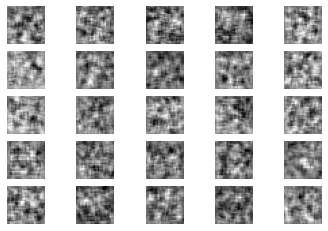

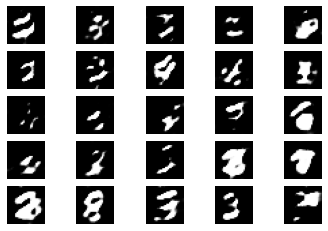

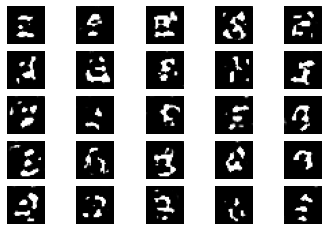

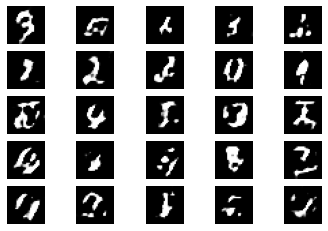

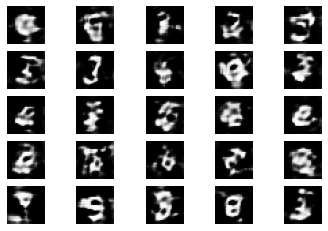

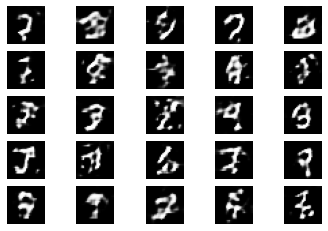

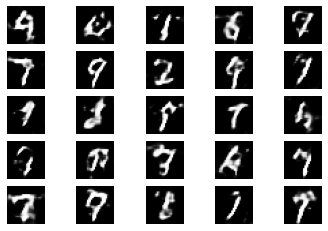

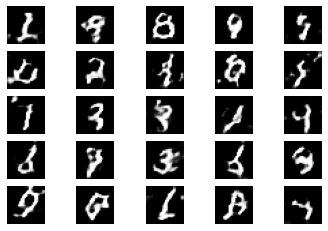

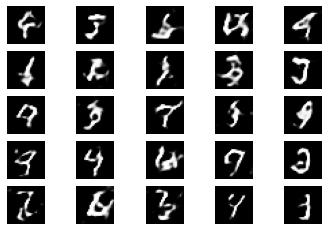

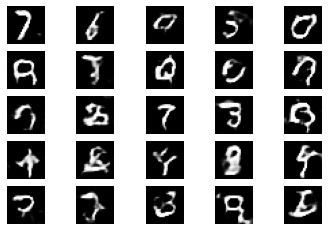

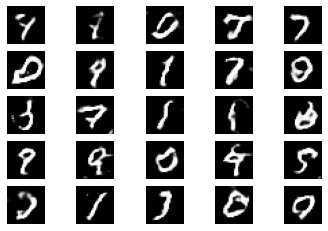

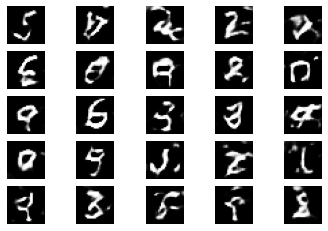

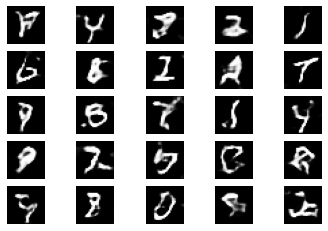

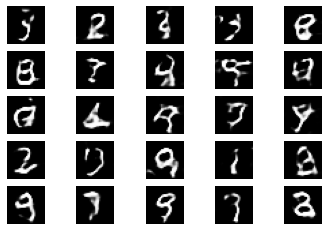

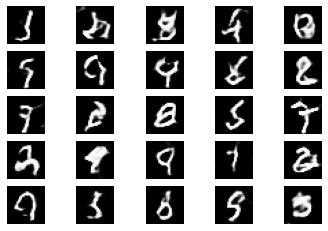

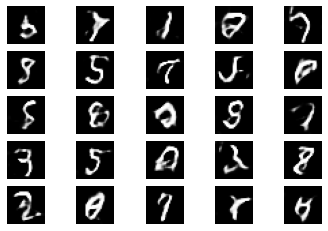

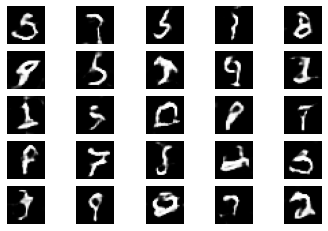

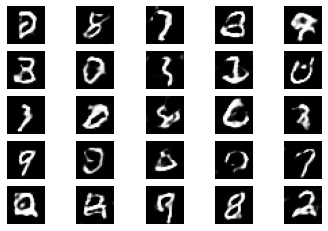

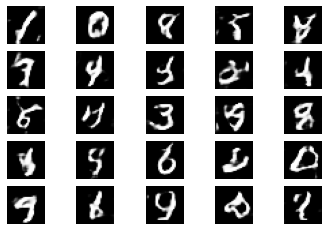

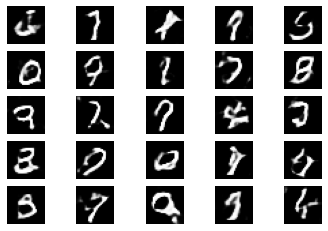

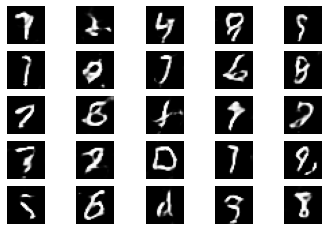

In [28]:
gan_train(4001, 32, 200)